In [1]:
import os
if '_cwd_set' not in locals(): locals()['_cwd_set'] = os.chdir(os.path.dirname(os.getcwd()))
import omnifig as fig
fig.initialize()
from src.jimports import *
from src.util import set_default_device, repo_root, data_root
from src.dataset import RawCOCO, SimpleCOCO
from src.pretrained import GPT2, BERT
device = set_default_device();

Selecting CUDA device 0 with 70382 MiB free memory and 0% utilization


In [2]:
dataset = SimpleCOCO(split='val').prepare()
dataset.size

5000

In [3]:
root = repo_root() / 'templates'

templates = load_yaml(root / 'add-cls.yml')
len(templates)

50

In [4]:
labels = dataset.label_space.class_names
len(labels)

80

In [5]:
labels

('person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush')

In [11]:
_irregular_plurals = {
    'person': 'people',
    'child': 'children',
    'foot': 'feet',
    'tooth': 'teeth',
    'scissors': 'scissors',
    'couch': 'couches',
    'sandwich': 'sandwiches',
    'skis': 'skis',
    'bench': 'benches',
}
def pluralize(label):
    if label in _irregular_plurals: return _irregular_plurals[label]
    return f'{label}s' if label[-1] != 's' else f'{label}es'
plurals = {label: pluralize(label) for label in labels}

In [ ]:
# https://chatgpt.com/c/674d5c68-ac0c-8005-9100-be2ab8ca243d
add_templates = load_yaml(root / 'add-cls.yml')
remove_templates = load_yaml(root / 'remove-cls.yml')
replace_templates = load_yaml(root / 'replace-cls.yml')

In [ ]:
def fill_in(templates, **info):
    return [line.format(**info) for line in templates]
filled = {}

add_lines = {label: fill_in(add_templates, label=label, plural=plurals[label]) for label in labels}
remove_lines = {label: fill_in(remove_templates, label=label, plural=plurals[label]) for label in labels}
replace_lines = {(label1, label2): fill_in(replace_templates, 
                                           label1=label1, label2=label2, 
                                           plural1=plurals[label1], plural2=plurals[label2]) 
                                           for label1 in labels for label2 in labels}

len(add_lines), len(remove_lines), len(replace_lines)

(80, 80, 6400)

In [15]:
lbl = random.choice(labels)
add_lines[lbl]

['Could you add a tv to the image?',
 'Please include at least one tv without altering the existing composition too much.',
 'Consider adding a tv to enhance the scene.',
 'A tv would be a great addition here!',
 'It would be nice to see a tv included.',
 'Can you incorporate a tv into the picture?',
 'Let’s add a tv to complete the scene.',
 'Adding a tv might improve the overall look.',
 'What about including a tv in this image?',
 'Could we see a tv somewhere in this shot?',
 'I think a tv would fit perfectly in this scene.',
 'How about integrating a tv into the design?',
 'Add a tv while keeping the current elements intact.',
 'A single tv could make this image pop!',
 'Would you mind placing a tv in the frame?',
 'Insert a tv to balance the visual elements.',
 'Sprinkle in a tv for a touch of variety.',
 'A tv could bring some life to this image.',
 'Let’s add just one tv to the mix.',
 'I’d like to see a tv in this composition.',
 'Please throw in a tv for added effect.',
 'A to

In [47]:
# model = GPT2().prepare(device=device)
model = BERT().prepare(device=device)
def get_embeddings(lines):
    with torch.no_grad():
        ctx = Context(model)
        ctx['text'] = lines
        return ctx['output']

In [48]:
emb = get_embeddings(add_lines[lbl])
emb.min(), emb.max()

(tensor(-9.1213, device='cuda:0'), tensor(4.2966, device='cuda:0'))

cup stop sign


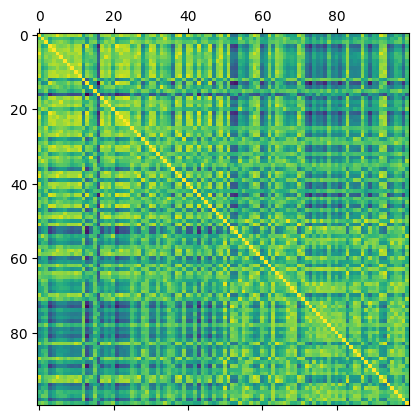

In [ ]:
lbl1, lbl2 = random.sample(labels, 2)
print(lbl1, lbl2)
embs = torch.cat([get_embeddings(add_lines[lbl1]), get_embeddings(add_lines[lbl2])], dim=0)
# embs = torch.cat([get_embeddings(add_lines[lbl1]), get_embeddings(replace_lines[lbl1, lbl2])], dim=0)
# similarity matrix
sim = F.normalize(embs, dim=1) @ F.normalize(embs, dim=1).T
plt.matshow(sim.cpu().numpy())

In [70]:
dataroot = Path('/data/felix/cache/static')

dat = hf.File(dataroot / 'coco-bert-text-interventions.h5', 'a')

In [ ]:
dat.attrs['labels'] = labels
dat.attrs['add_templates'] = add_templates
dat.attrs['remove_templates'] = remove_templates
dat.attrs['replace_templates'] = replace_templates

In [83]:
get_embeddings(add_lines[lbl1]).dtype

torch.float32

In [ ]:
dat.create_dataset('add_embeddings', (len(labels), len(add_templates), 768), dtype=np.float32)
for i, label in tqdm(enumerate(labels), total=len(labels)):
    dat['add_embeddings'][i] = get_embeddings(add_lines[label]).cpu().numpy()

  0%|          | 0/80 [00:00<?, ?it/s]

In [89]:
dat.create_dataset('remove_embeddings', (len(labels), len(remove_templates), 768), dtype=np.float32)
for i, label in tqdm(enumerate(labels), total=len(labels)):
    dat['remove_embeddings'][i] = get_embeddings(remove_lines[label]).cpu().numpy()

  0%|          | 0/80 [00:00<?, ?it/s]

In [90]:
dat.create_dataset('replace_embeddings', (len(labels), len(labels), len(replace_templates), 768), dtype=np.float32)
for i, label1 in tqdm(enumerate(labels), total=len(labels)):
    for j, label2 in enumerate(labels):
        dat['replace_embeddings'][i, j] = get_embeddings(replace_lines[label1, label2]).cpu().numpy()

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
dat.close()

In [92]:

dat = hf.File(dataroot / 'coco-bert-text-interventions.h5', 'r')

In [100]:
x, y = np.random.randint(0, len(labels), (2, 6))
# ord = np.argsort(x)
# x, y = x[ord], y[ord]
x, y

(array([76, 36, 55,  6, 40, 43]), array([78, 62, 64, 57, 37, 34]))

In [99]:
full = dat['replace_embeddings'][:]
full.shape

(80, 80, 50, 768)

In [102]:
full[x,y, 0].shape

(6, 768)

In [ ]:
'/data/felix/cache/static/coco-bert-text-interventions.h5'